In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as pyplot
from sklearn.model_selection import train_test_split

In [29]:
tf.debugging.set_log_device_placement(True)
# from google.colab import drive
# drive.mount('/content/drive')

In [35]:
# %cd drive/MyDrive/ml_data/
gpus = tf.config.list_physical_devices('GPU')
print(tf.test.gpu_device_name()+":")

:


In [11]:
train_csv_path = r'C:\Users\YanPC\Desktop\dataset\emotion\icml_face_data.csv'
emotions = {0: 'Angry', 1:'Disgust', 2:'Fear',3: 'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
df = pd.read_csv(train_csv_path)
df.head(5)

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


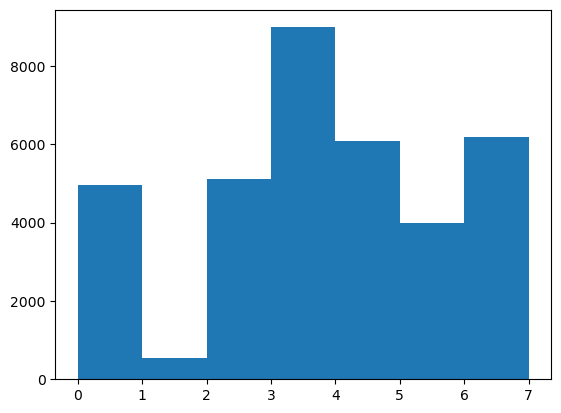

In [12]:
counts, bins = np.histogram(df['emotion'], list(range(0,8)))
pyplot.stairs(counts, bins, fill=True)

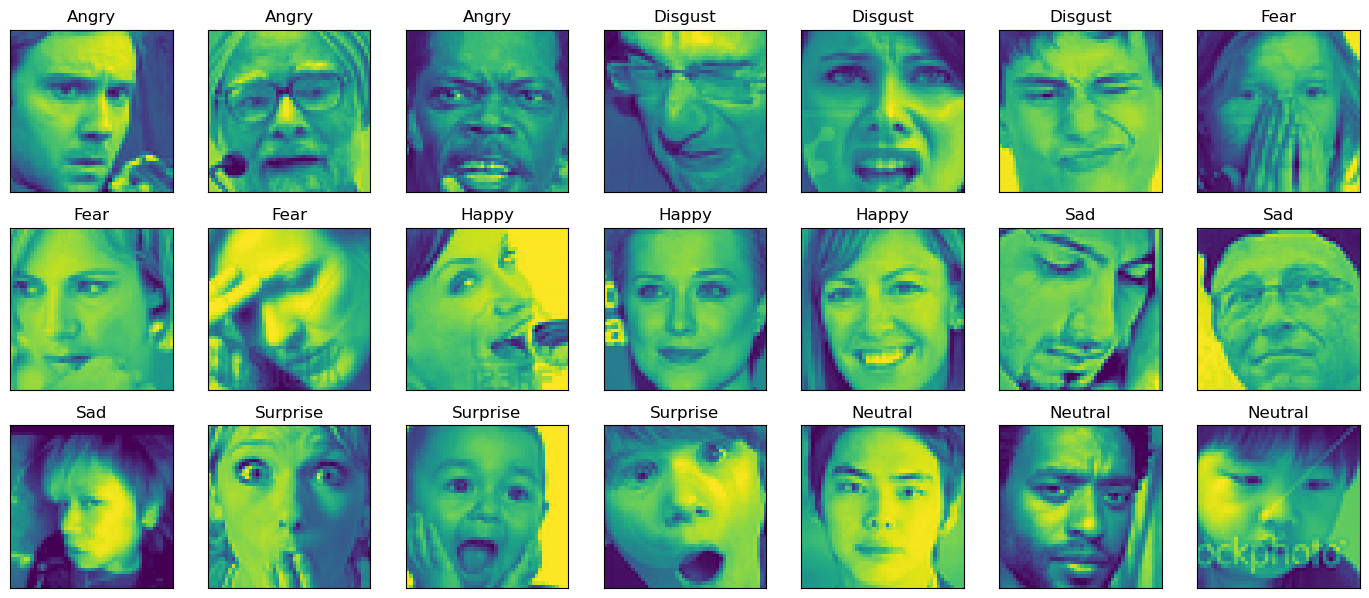

In [13]:
fig = pyplot.figure(1, (14, 14))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(3):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions[label])
        pyplot.tight_layout()

In [14]:
img_array = df.pixels.apply(lambda px : np.array(px.split(' ')).reshape(48, 48, 1).astype('float32'))

In [15]:
img_array = np.stack(img_array, axis=0)
labels = df.emotion.values

In [16]:
X_train, X_test, y_train, y_test = train_test_split(img_array, labels, test_size=0.2)

In [18]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [19]:
basemodel = tf.keras.Sequential([
tf.keras.layers.Conv2D(64, (5,5), activation='relu', input_shape=(48, 48, 1), padding='same'),
tf.keras.layers.Conv2D(64, (5,5), activation='relu', padding='same'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D((2,2)),

tf.keras.layers.Conv2D(128, (5,5), activation='relu', padding='same'),
tf.keras.layers.Conv2D(128, (5,5), activation='relu', padding='same'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D((2,2)),

tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.MaxPooling2D((2,2)),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(7, activation='softmax')
])

In [20]:
basemodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       4

In [21]:
basemodel.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [22]:
import os
try:
  os.mkdir('checkpoint')
except:
  pass

In [23]:
file_name = 'best_model.h5'
checkpoint_path = os.path.join('checkpoint', file_name)


call_back = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_accuracy', 
                                                 verbose=1,
                                                 save_freq='epoch',
                                                 save_best_only=True, 
                                                 save_weights_only=False, 
                                                 mode='max')

In [24]:
basemodel.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=call_back)

Epoch 1/20
 15/718 [..............................] - ETA: 33:06 - loss: 1.9177 - accuracy: 0.2354

KeyboardInterrupt: 

Actual label is Neutral
1/1 [==============================] - 0s 19ms/step
Predicted label is Neutral


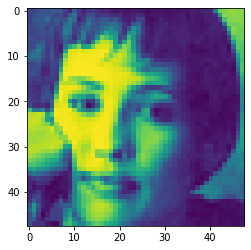

In [71]:
final_model = tf.keras.models.load_model(checkpoint_path)
from IPython.display import clear_output
import time

for k in range(3):
  print(f'Actual label is {emotions[y_test[k]]}')
  predicted_class = final_model.predict(tf.expand_dims(X_test[k], 0)).argmax()
  print(f'Predicted label is {emotions[predicted_class]}')
  pyplot.imshow(X_test[k])
  pyplot.show()
  time.sleep(3)
  clear_output(wait=True)
